In [1]:
import stockinator as st
import yfinance as yf
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
from mplfinance.original_flavor import candlestick_ohlc
import datetime
import time
import os
import sys
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

In [3]:
data = pd.read_pickle('stocks/all_1d.pkl')
stocklist = st.unique_list([x[0] for x in data.columns.values])
total_stocks = len(stocklist)

In [2]:
def plot_chart(data, n, ticker):
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 8))   
    
    ax_candle = fig.add_axes((0, 0.72, 1, 0.90))
    ax_vol = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)

    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    ax_candle.set_title(ticker)
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index, data['SMA_21'], label='SMA_21')
    ax_candle.plot(data.index, data['SMA_55'], label='SMA_55')
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Show volume in millions
    ax_vol.bar(data.index, data["Volume"] / 1000000)
    ax_vol.set_ylabel("(Million)")
   
    
    # Save the chart as PNG
    fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
    plt.show()
    


In [10]:
stocks = {}
for stock in stocklist:
    df = data[stock]
    df = df.dropna(how='all')
    if df.empty:
        continue
        
    consolidation_length = 13
    df['SMA'] = ta.SMA(df.Close.values, timeperiod=consolidation_length)
    if df['Close'][-1] < df['SMA'][-1]:
        continue
        
    df = df[-consolidation_length:]
    
    #df = df[df['Close'].max() < df['Close'] * 1.03]
    #df = df[df['Close'].min() > df['Close'] * 0.97]
    
    df = df[df['Close'] < df['SMA'] * 1.02]
    df = df[df['Close'] > df['SMA'] * 0.98]
    
    if len(df) == consolidation_length:
        match = data[stock].dropna(how='all')
        if match['Volume'][-1] < 250000:
            continue
            
        match['RSI'] = ta.RSI(match.Close.values, timeperiod=14)
        match['SMA_21'] = ta.SMA(match.Close.values, timeperiod=21)
        match['SMA_55'] = ta.SMA(match.Close.values, timeperiod=55)
        match['MFI'] = ta.MFI(match['High'], match['Low'], match['Close'], match['Volume'], timeperiod=14)
        match = st.calculate_volume(match)
        stocks[stock] = match
 

Found 26 Matches


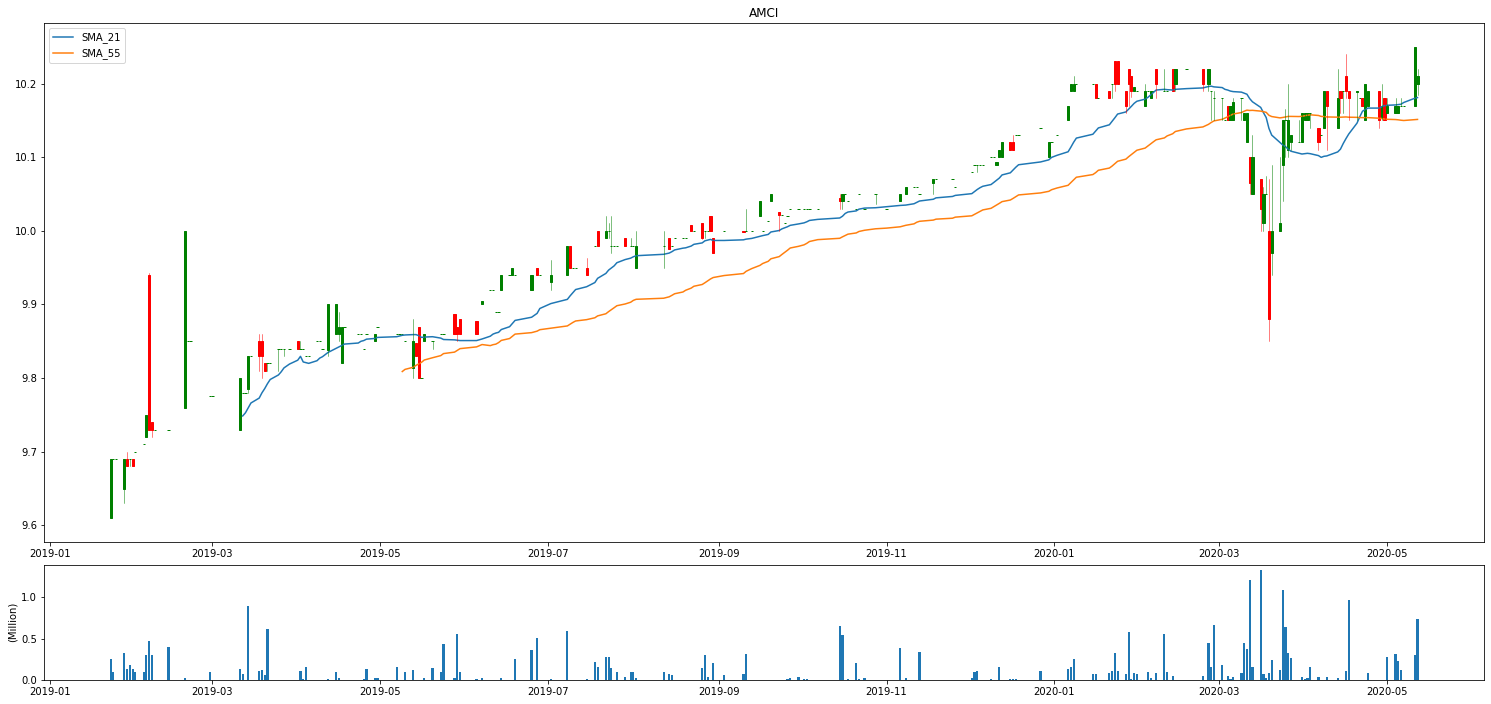

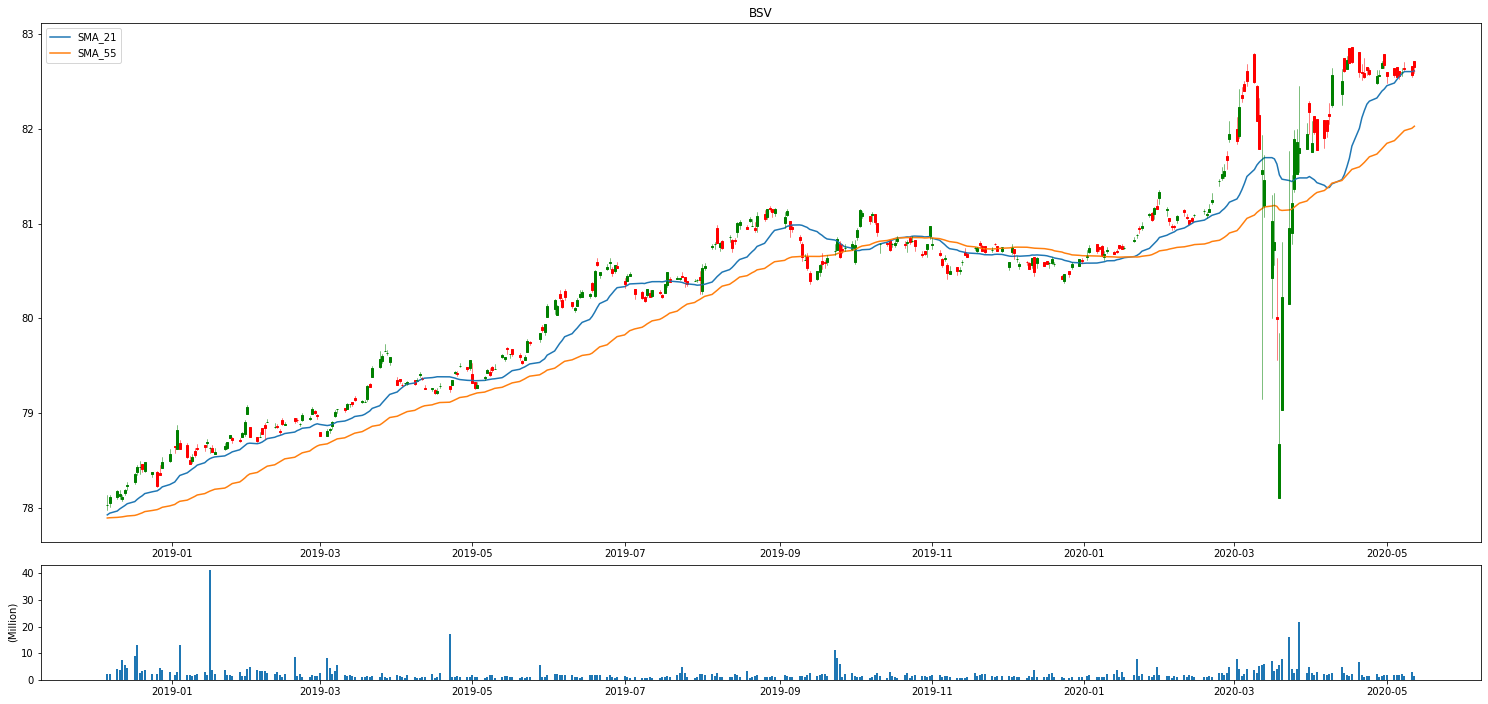

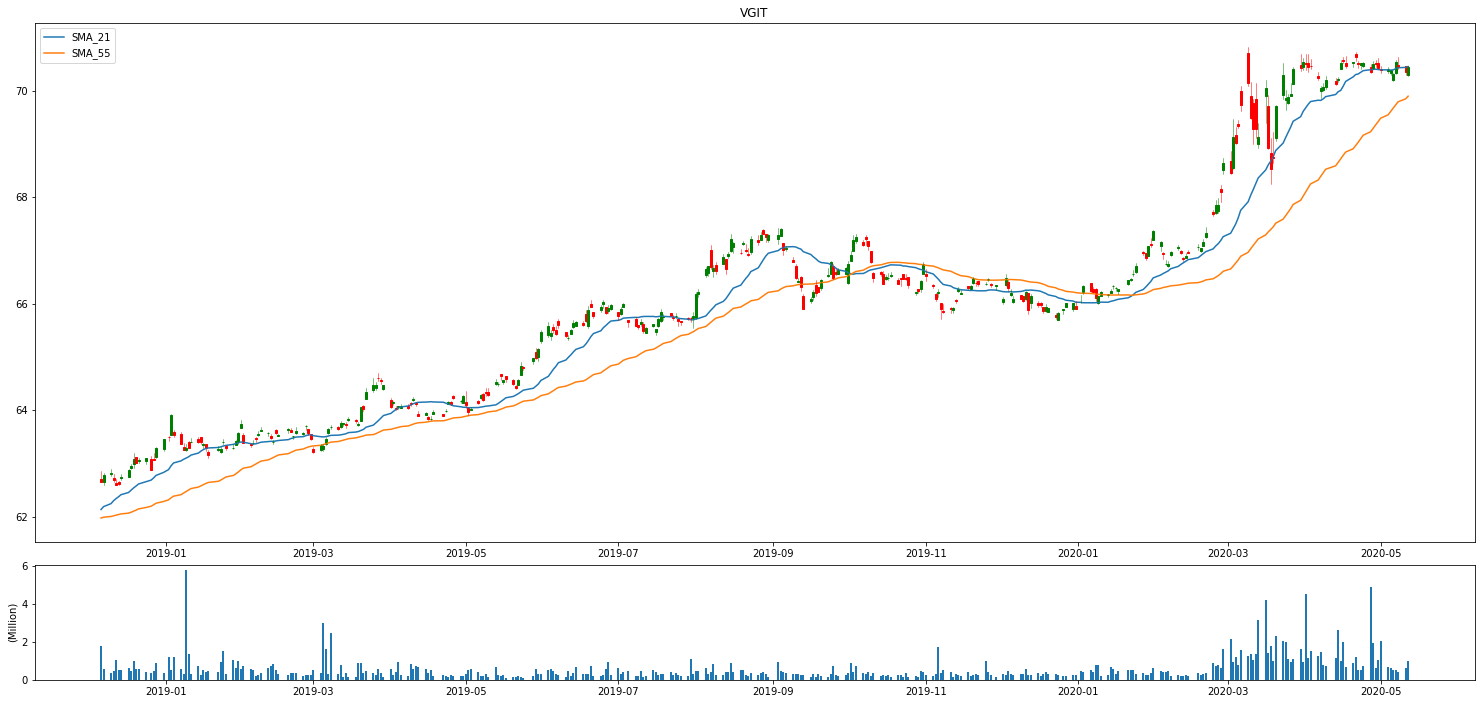

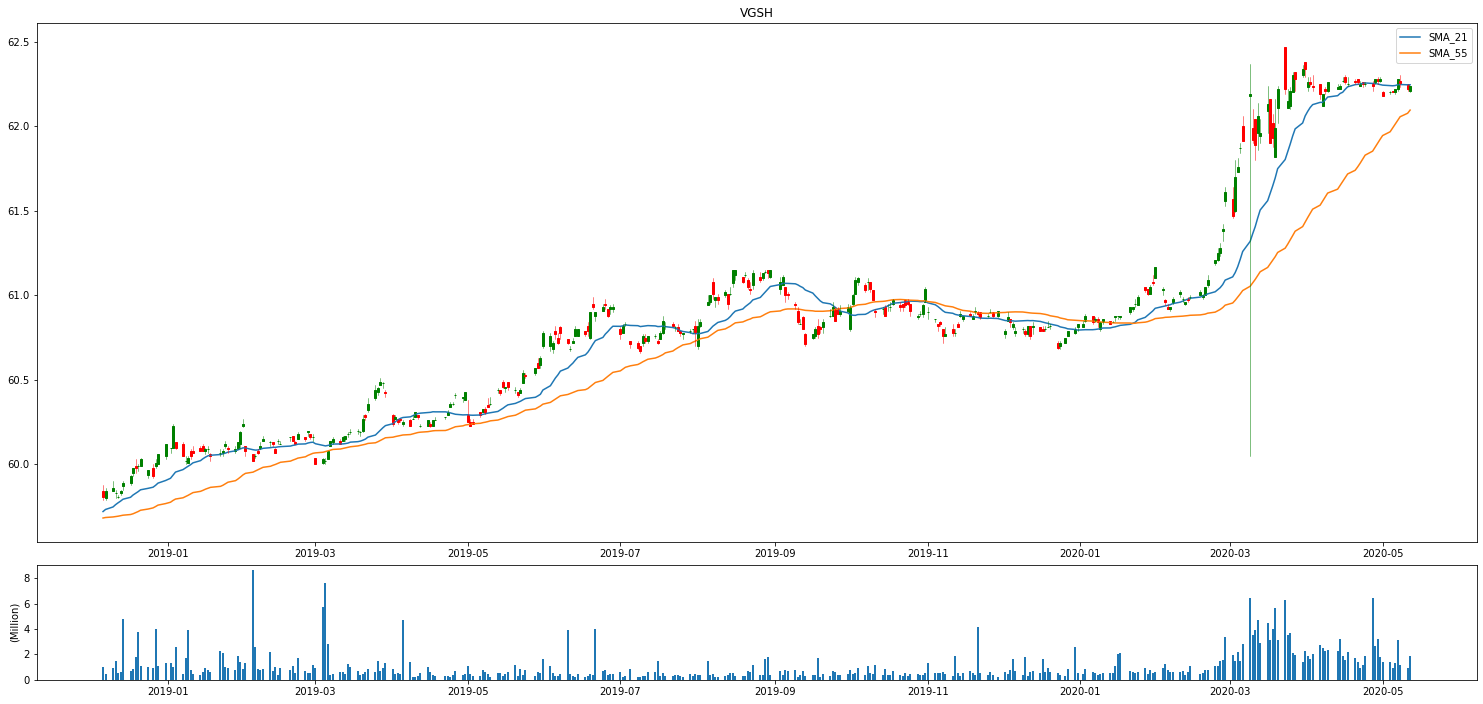

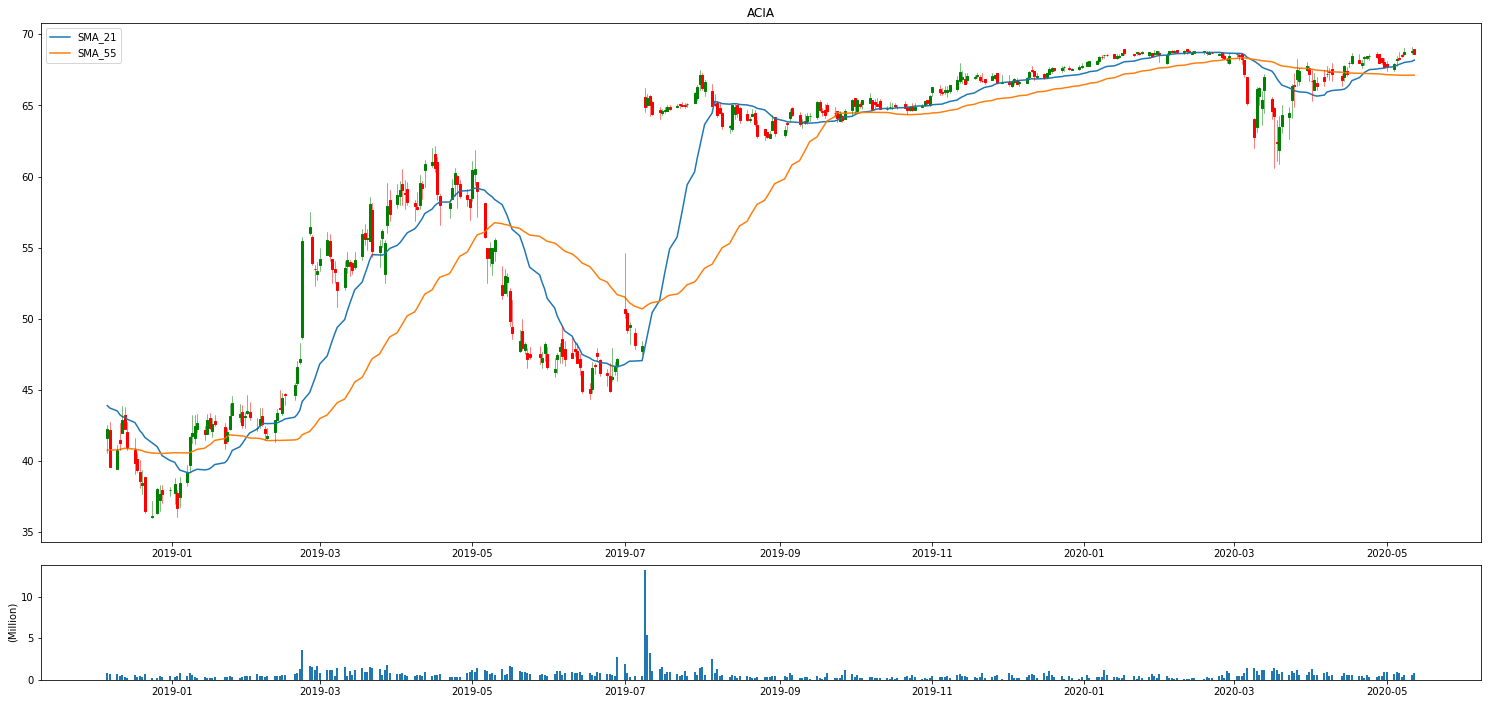

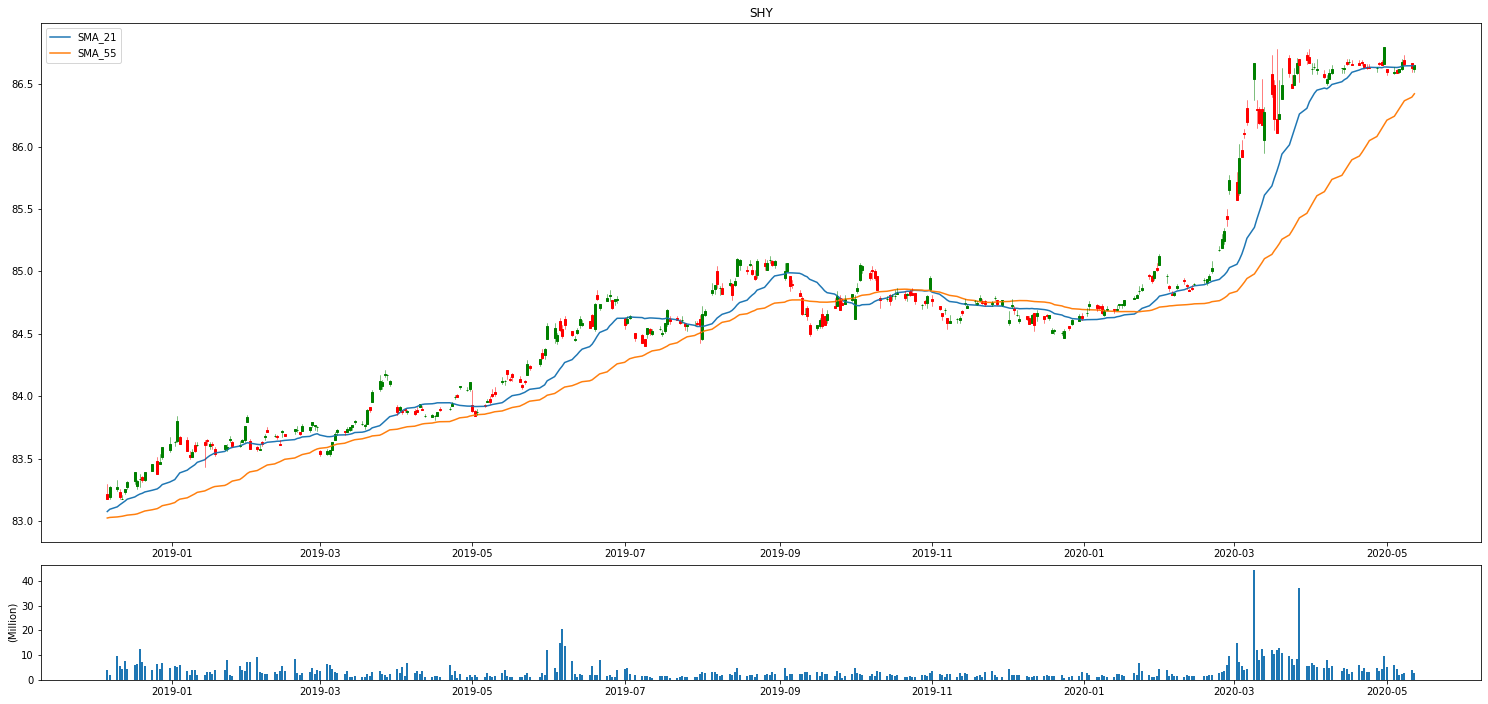

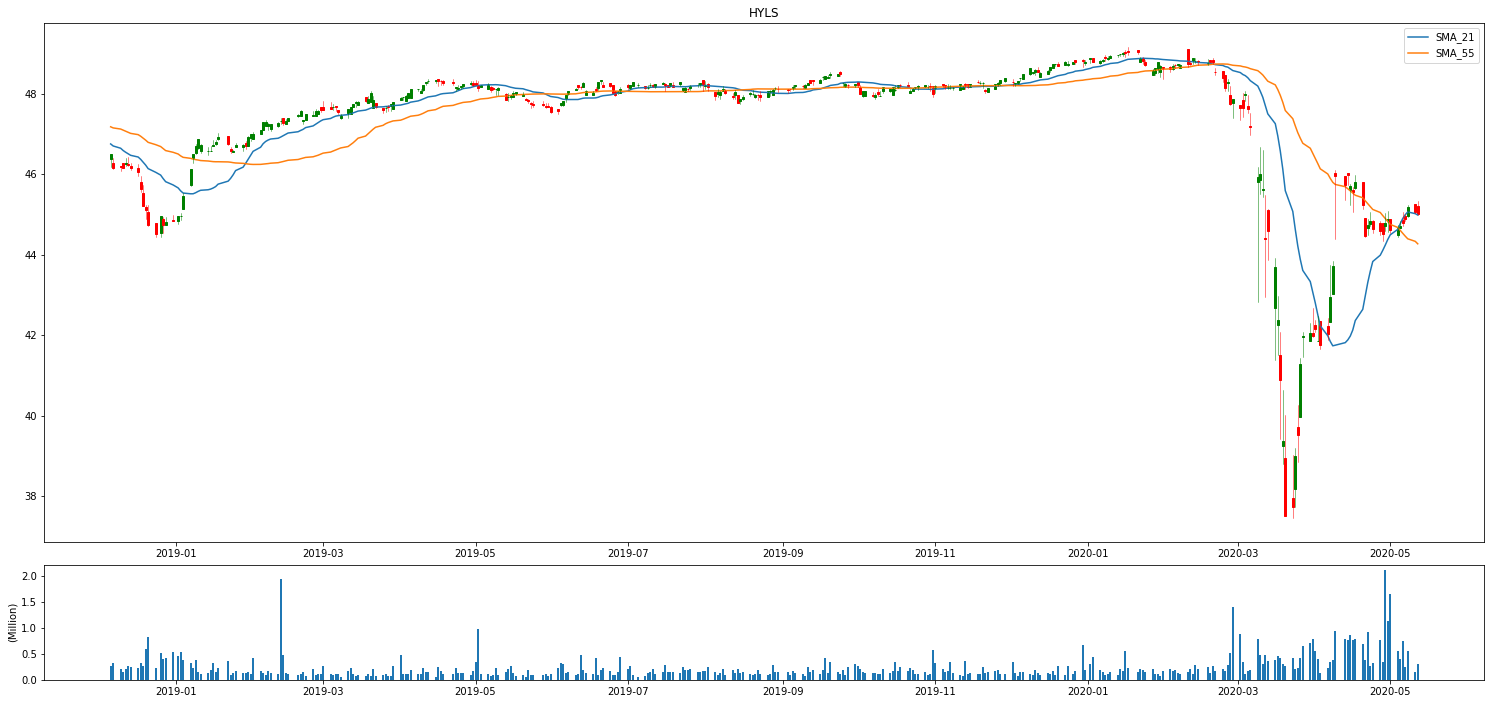

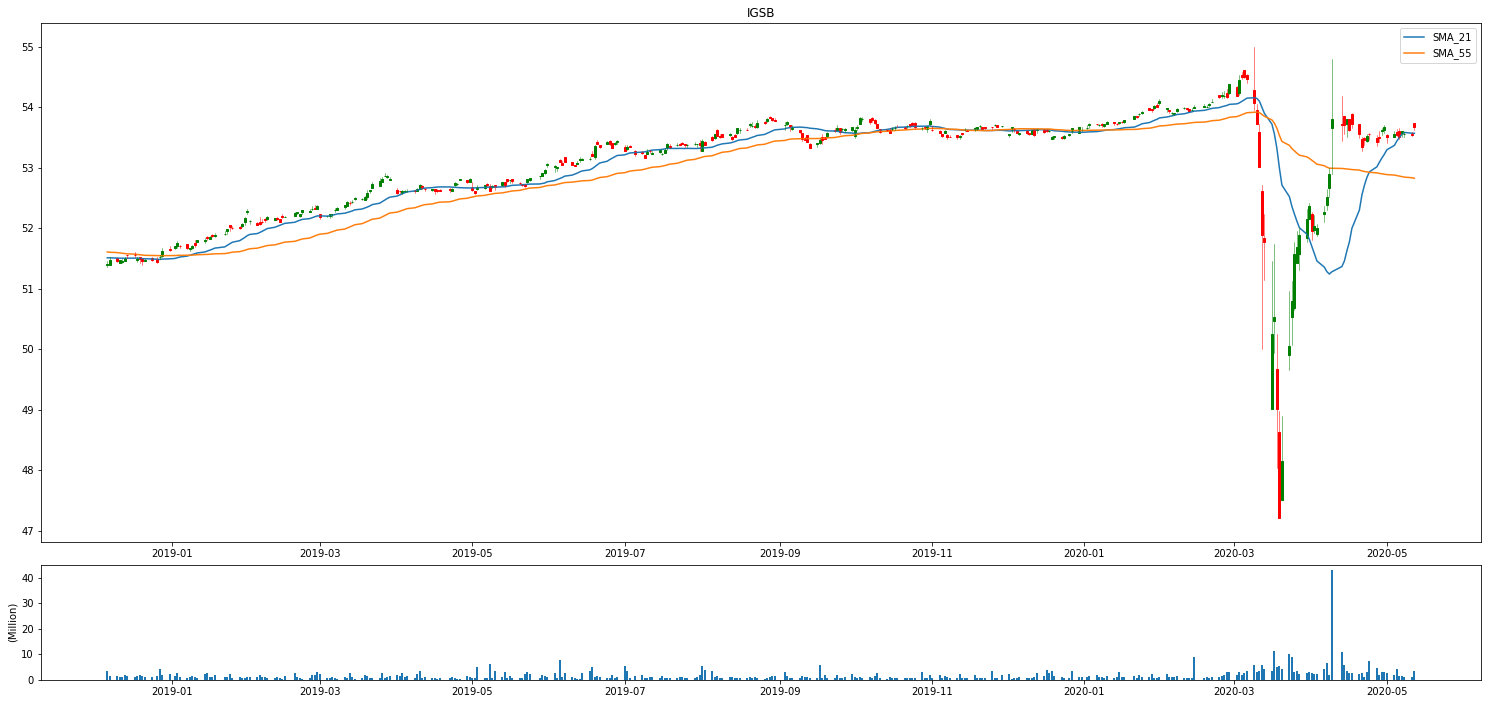

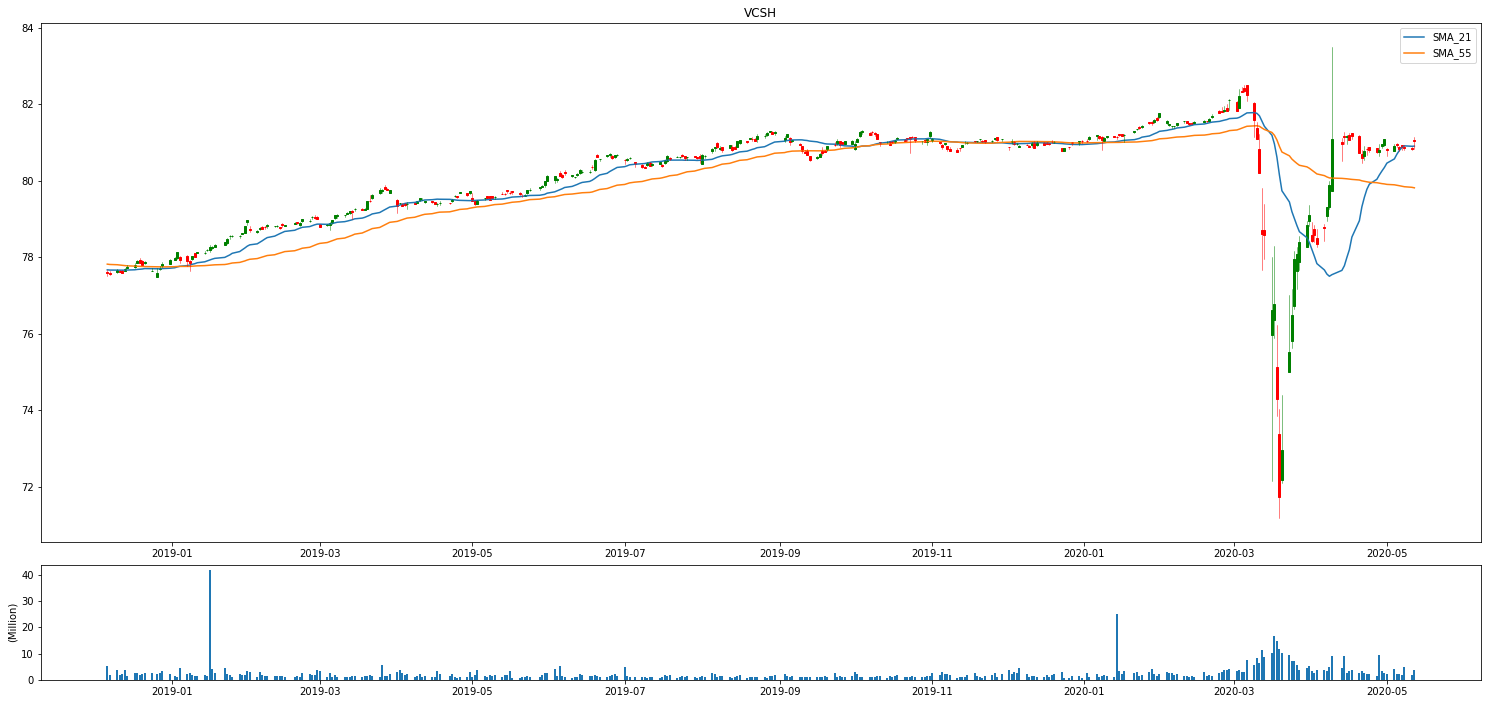

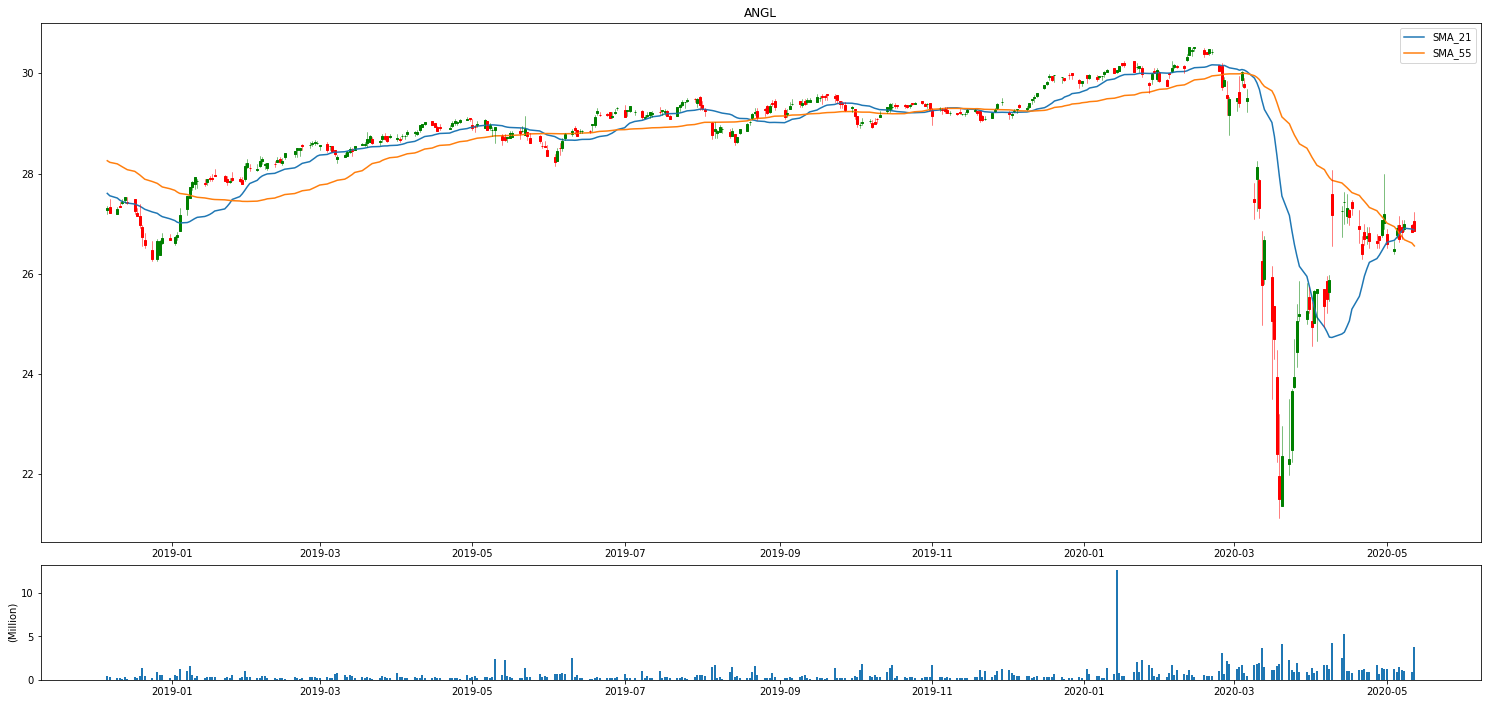

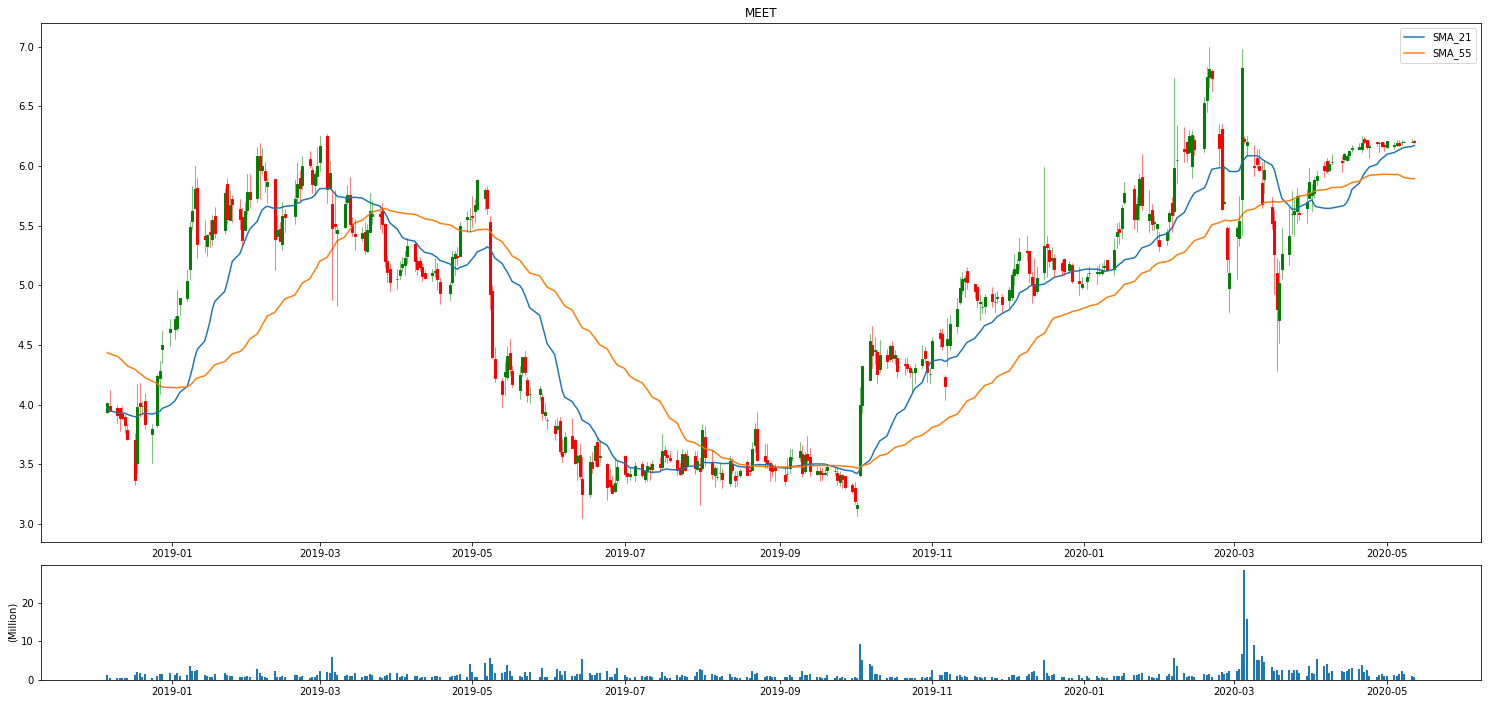

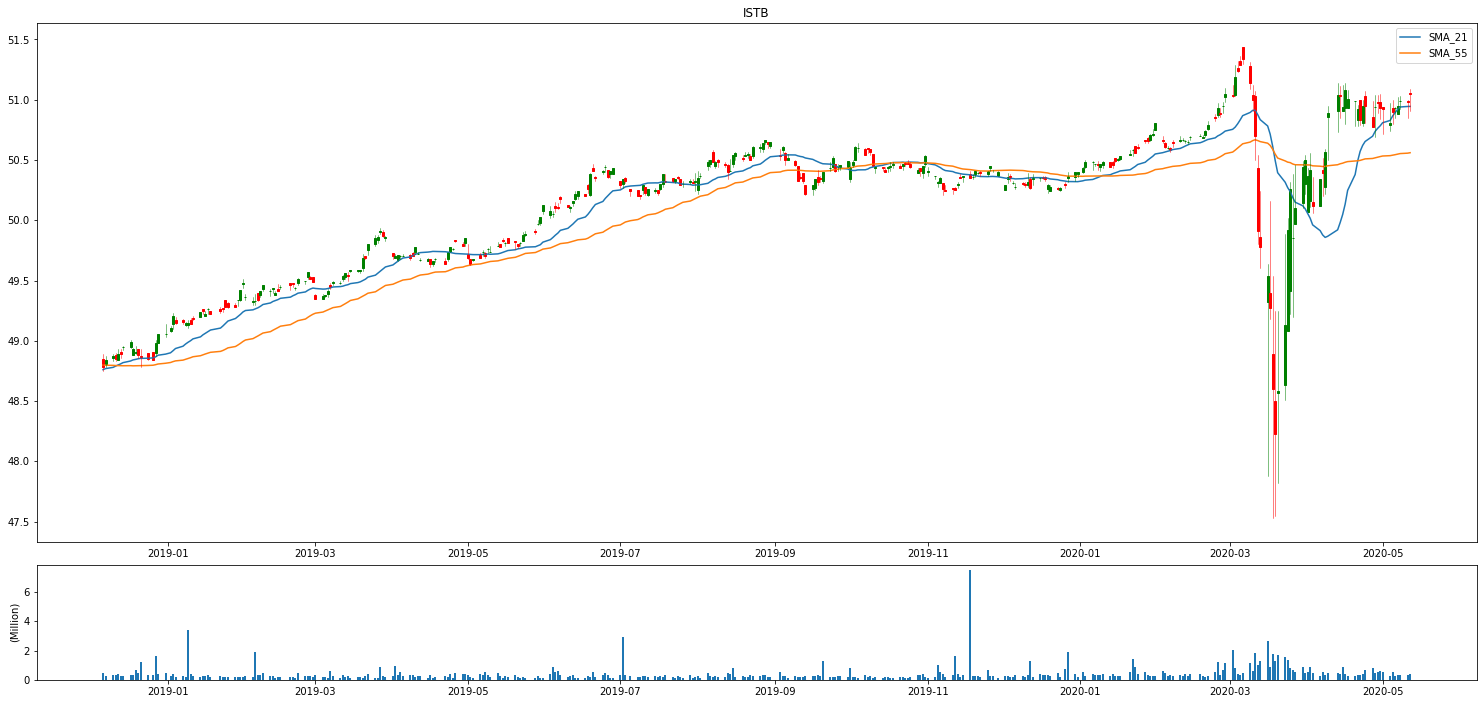

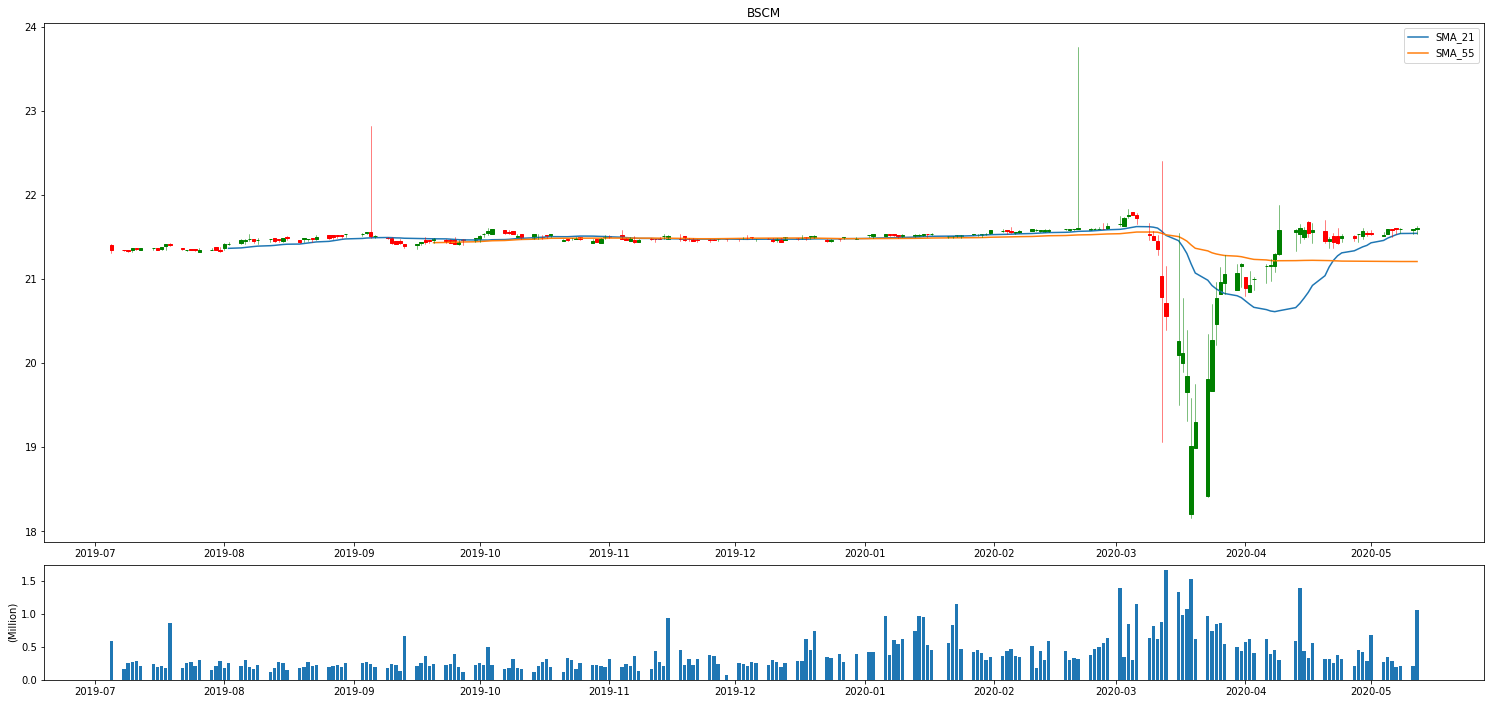

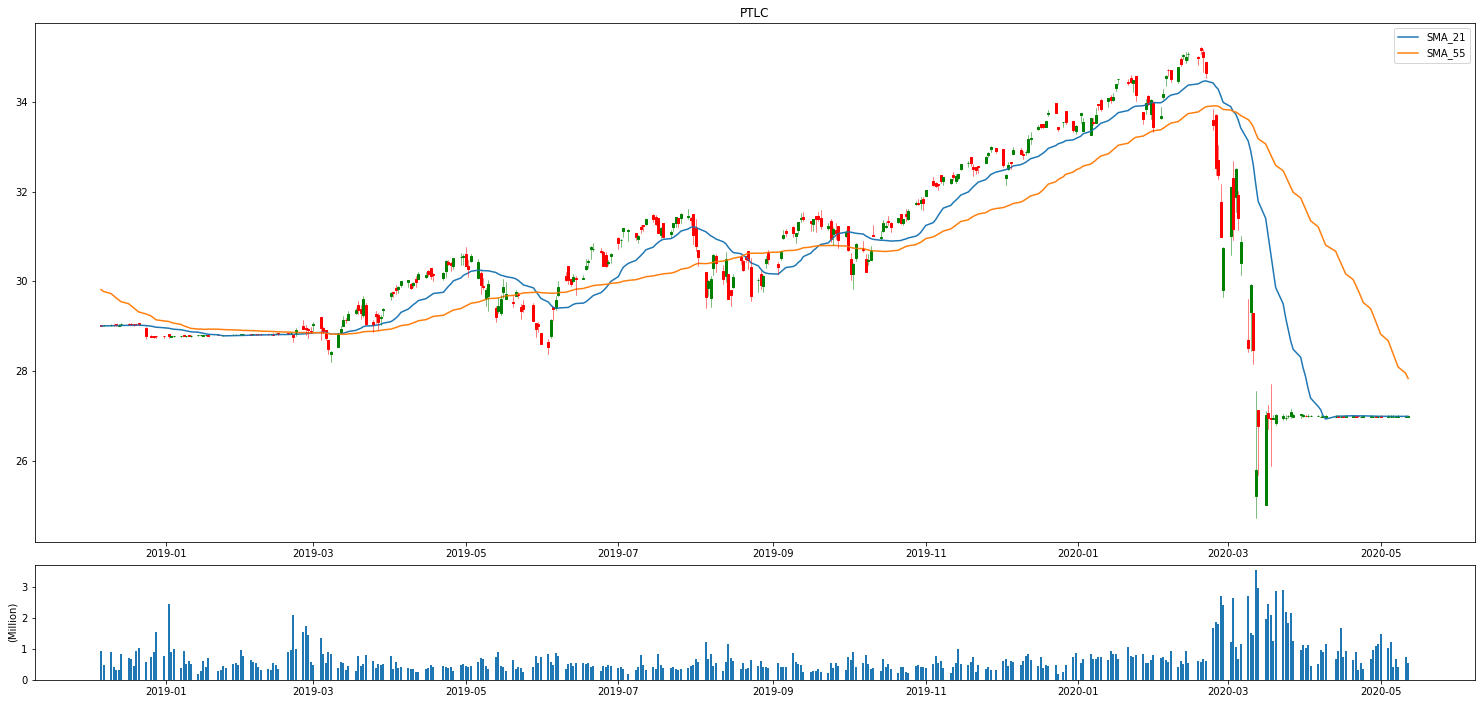

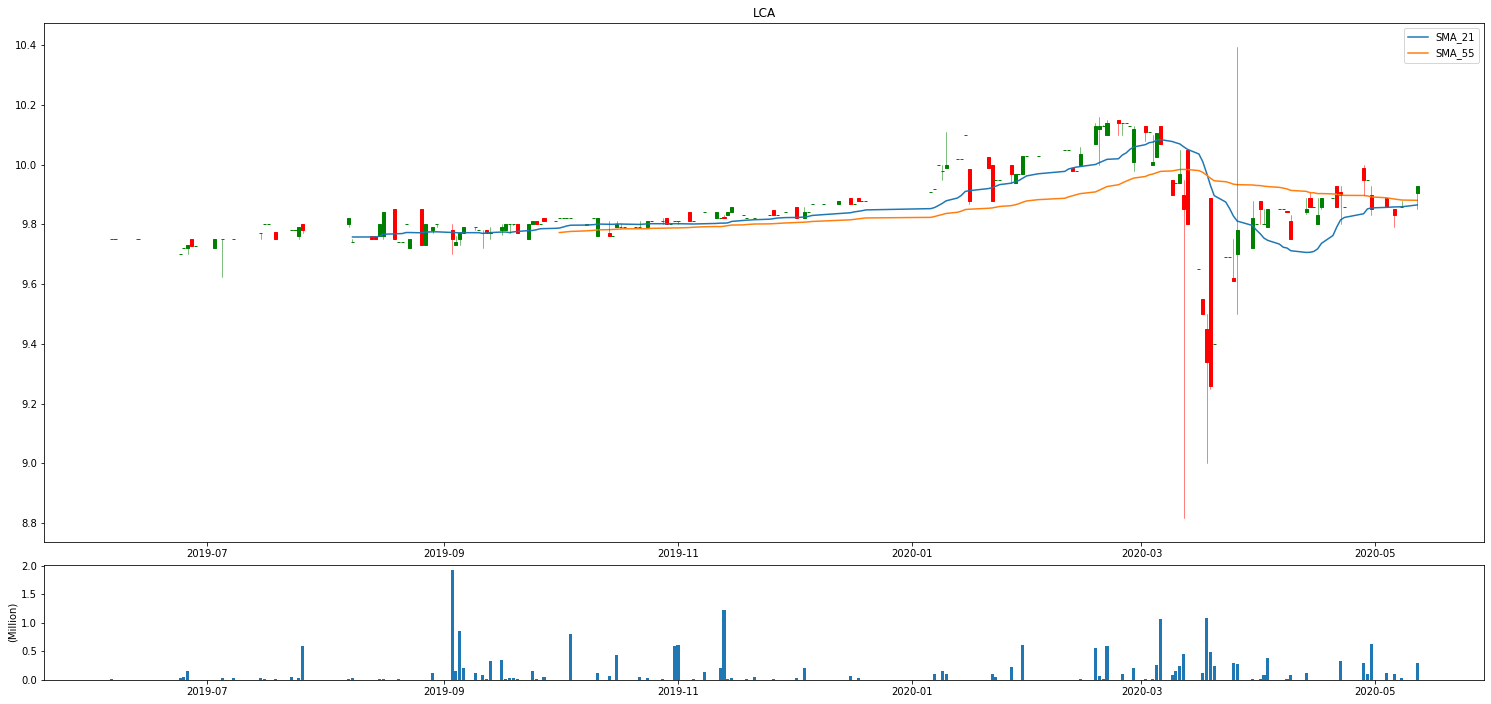

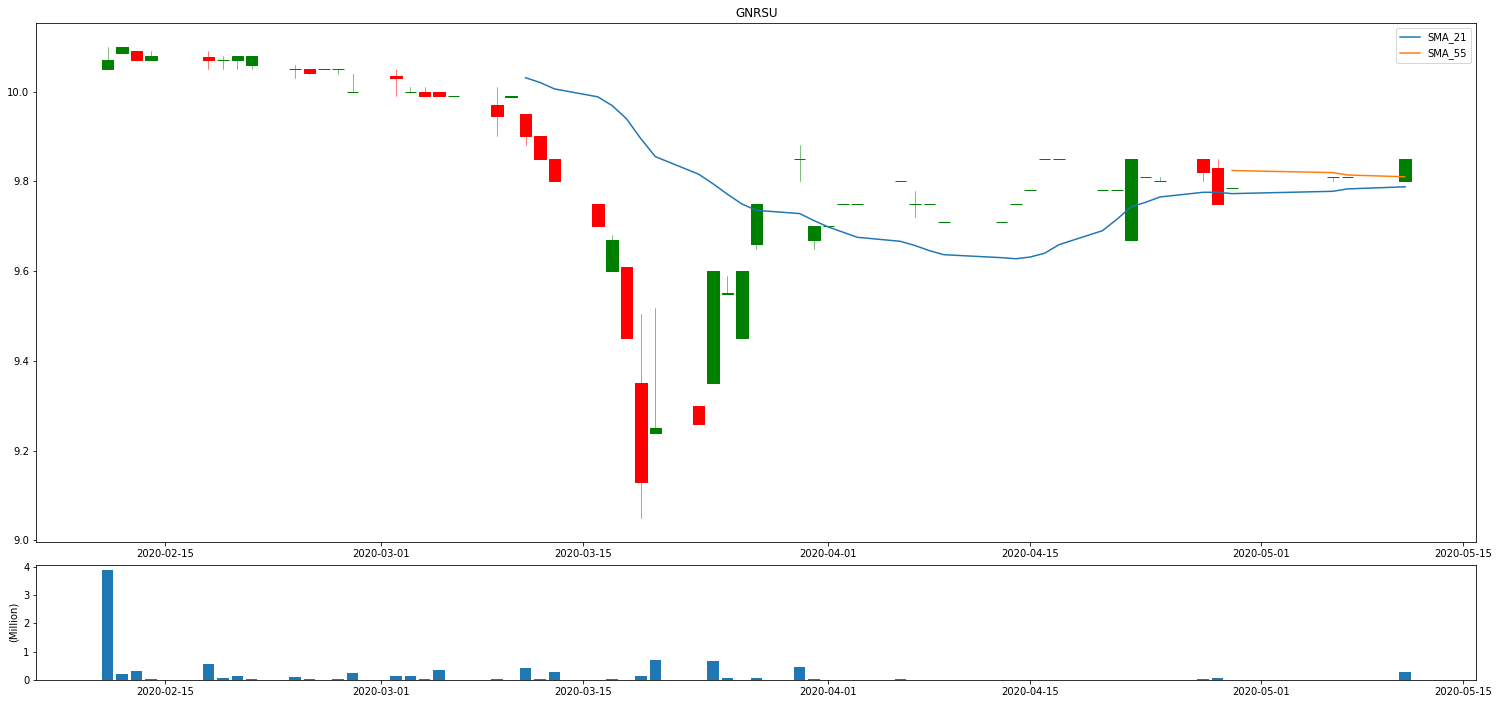

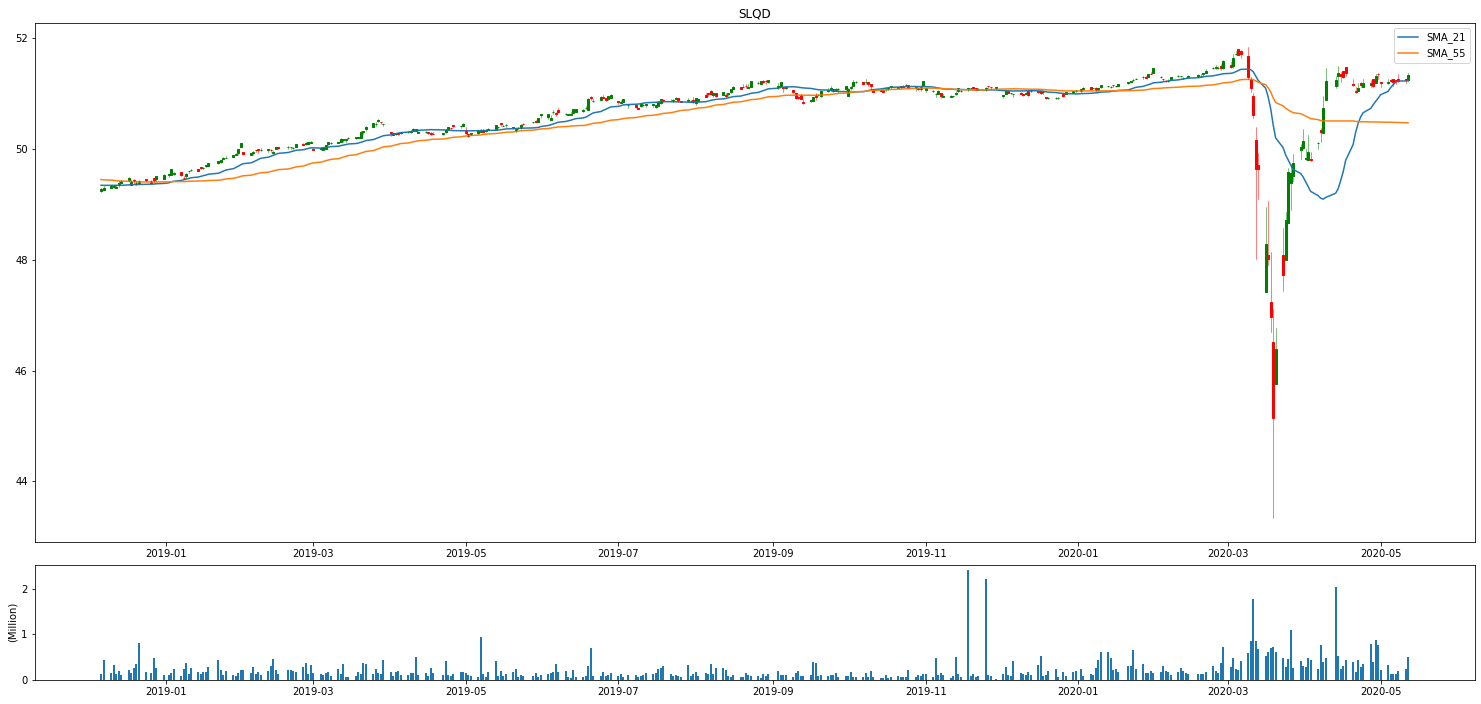

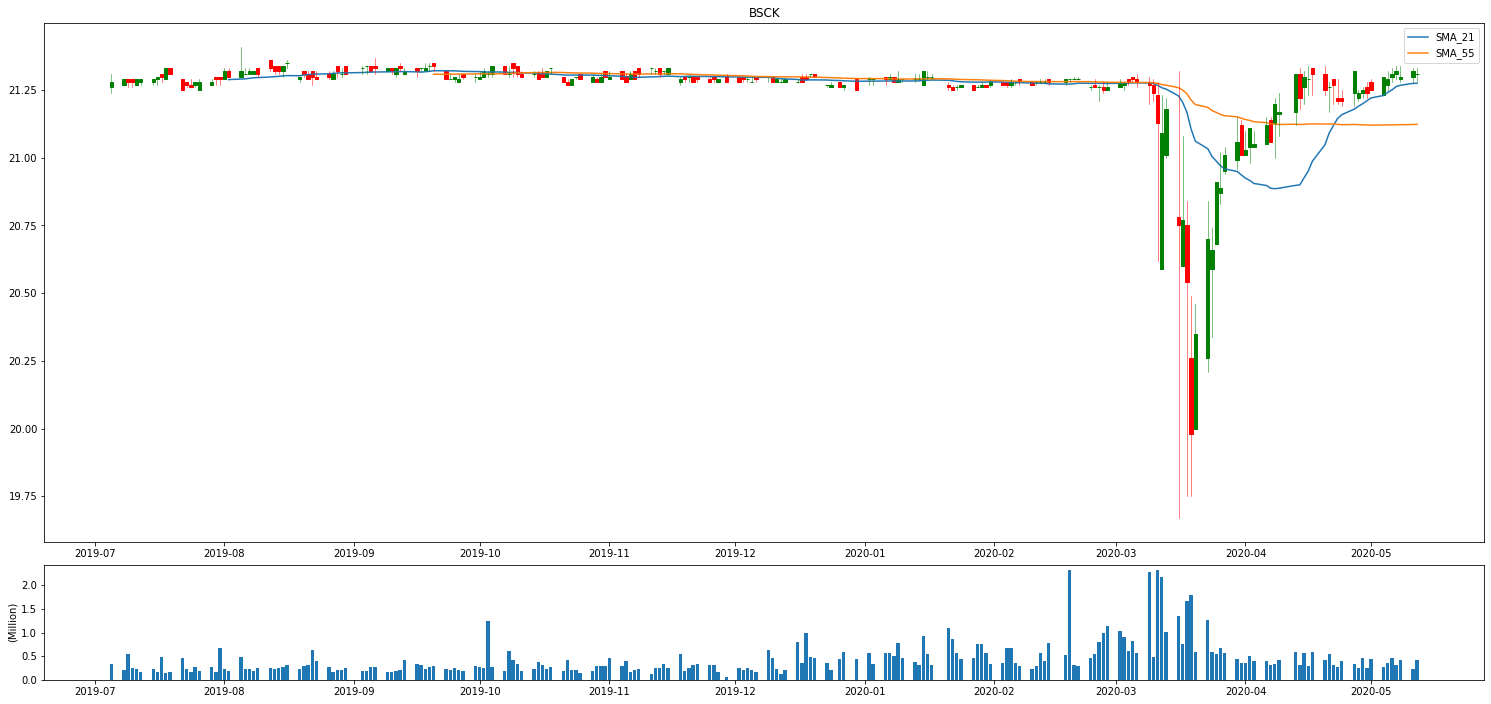

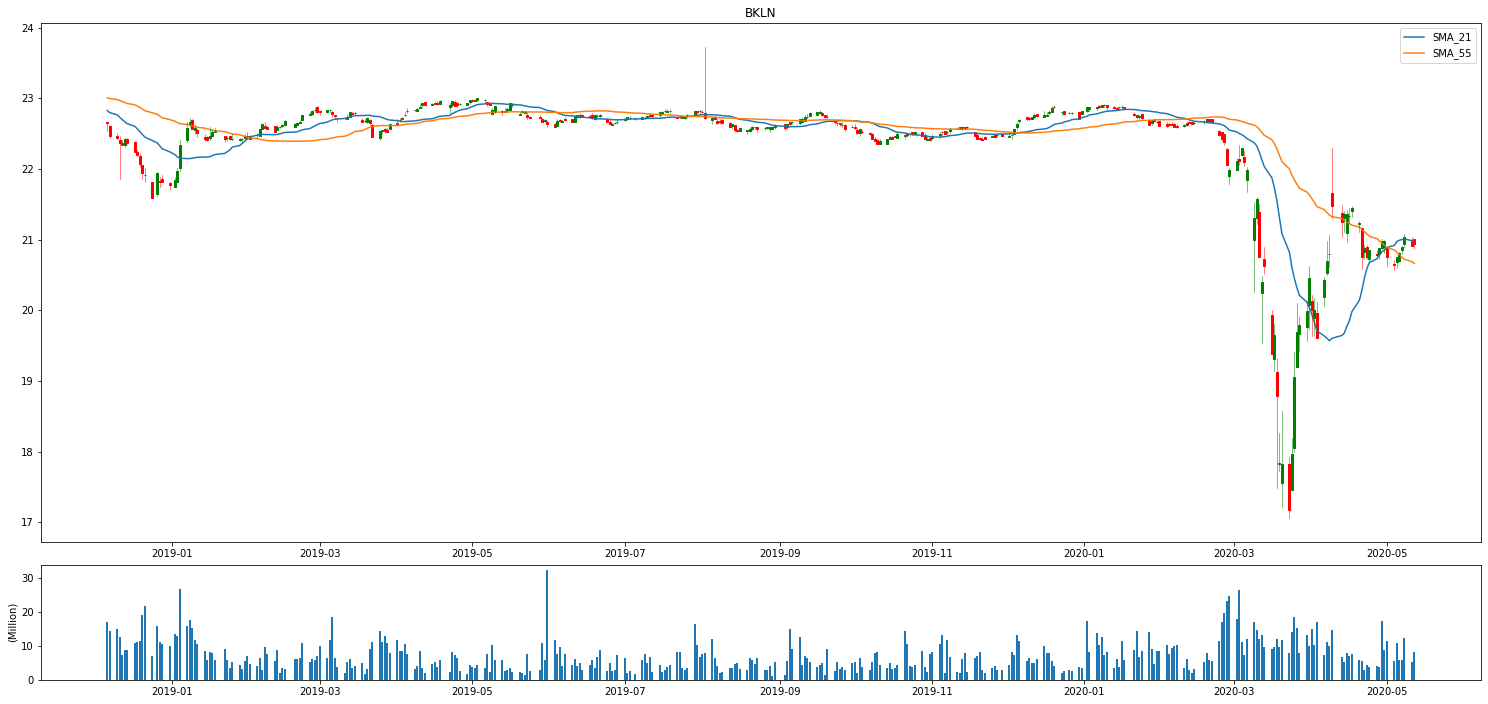

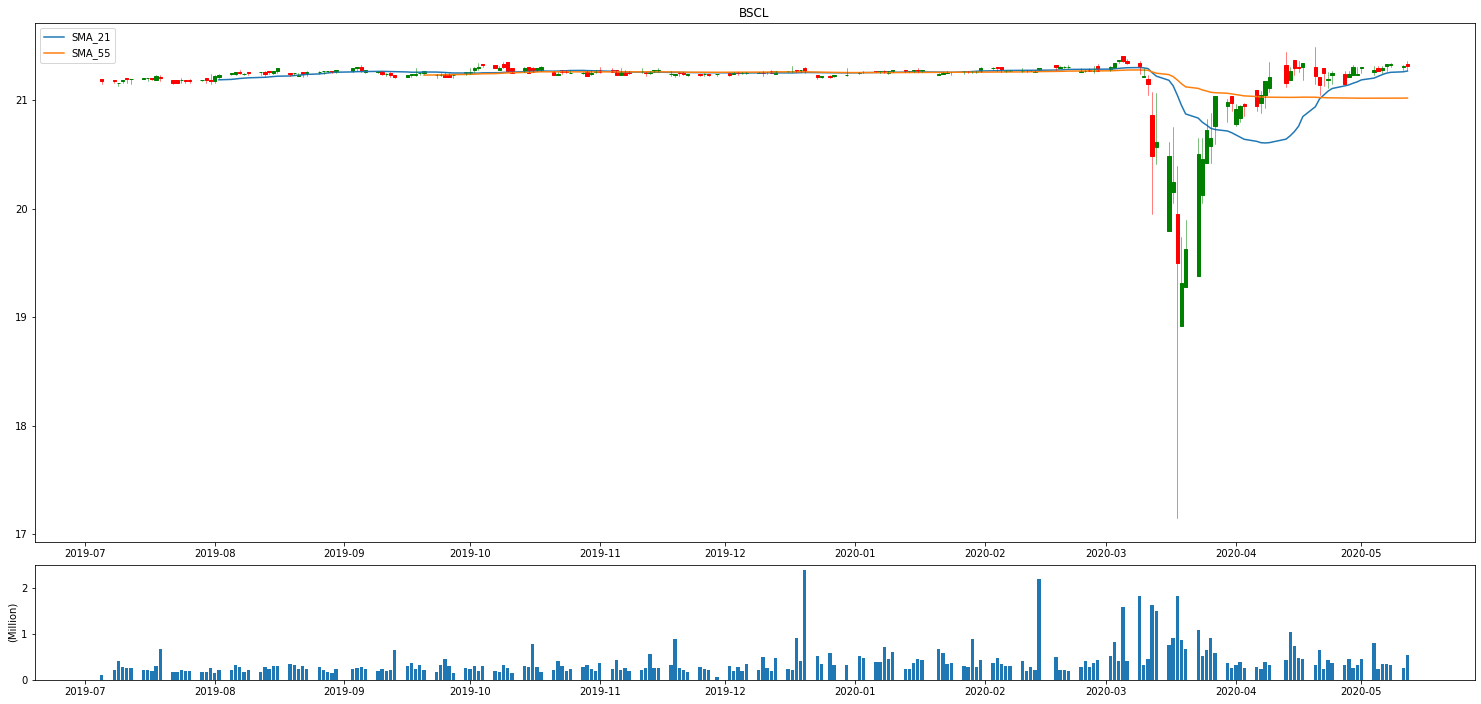

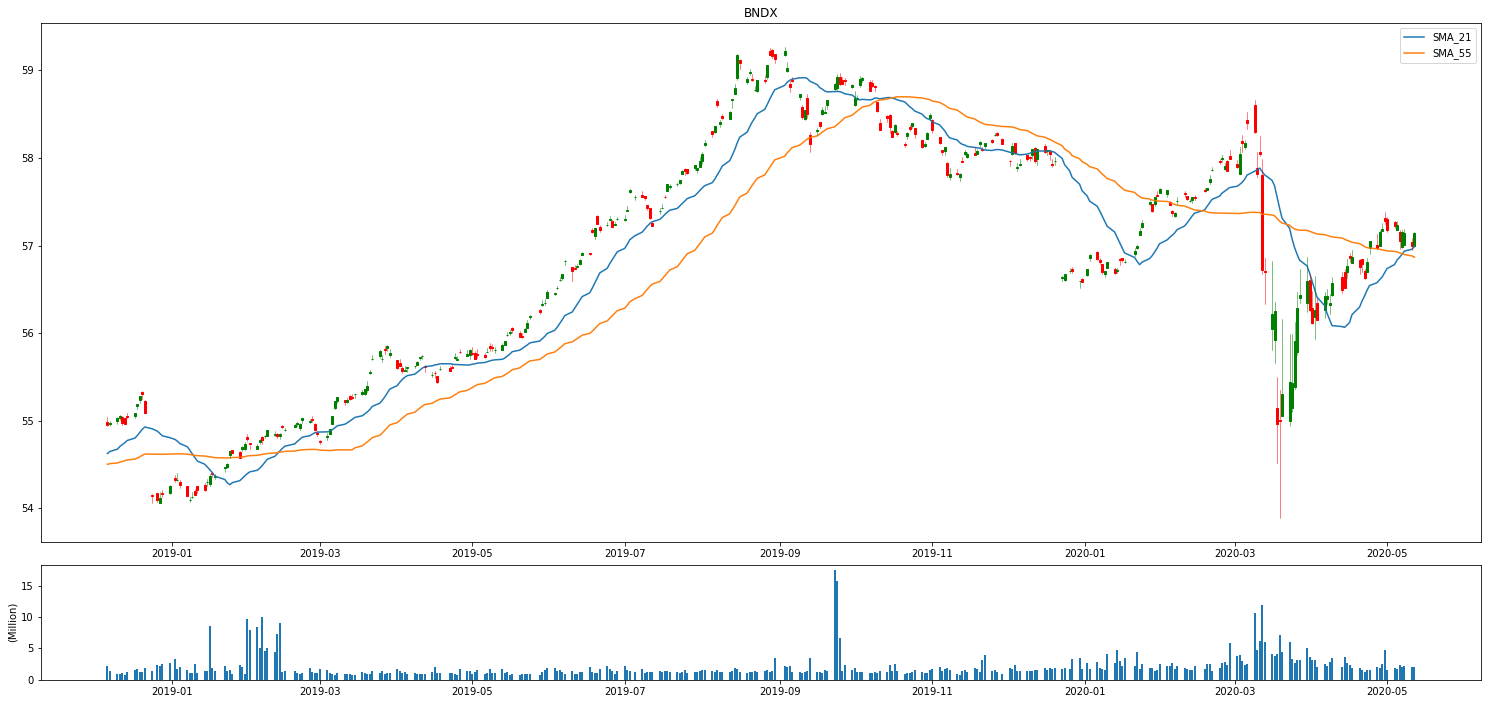

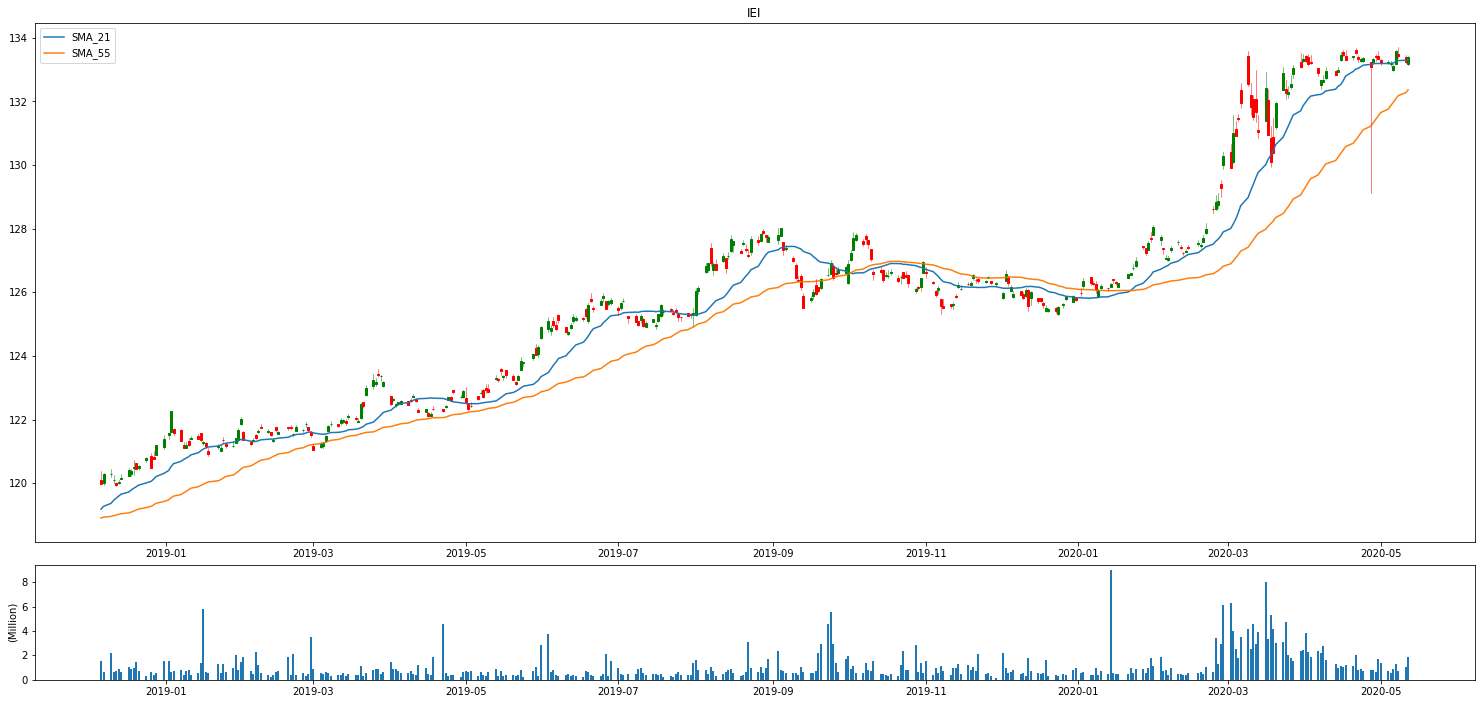

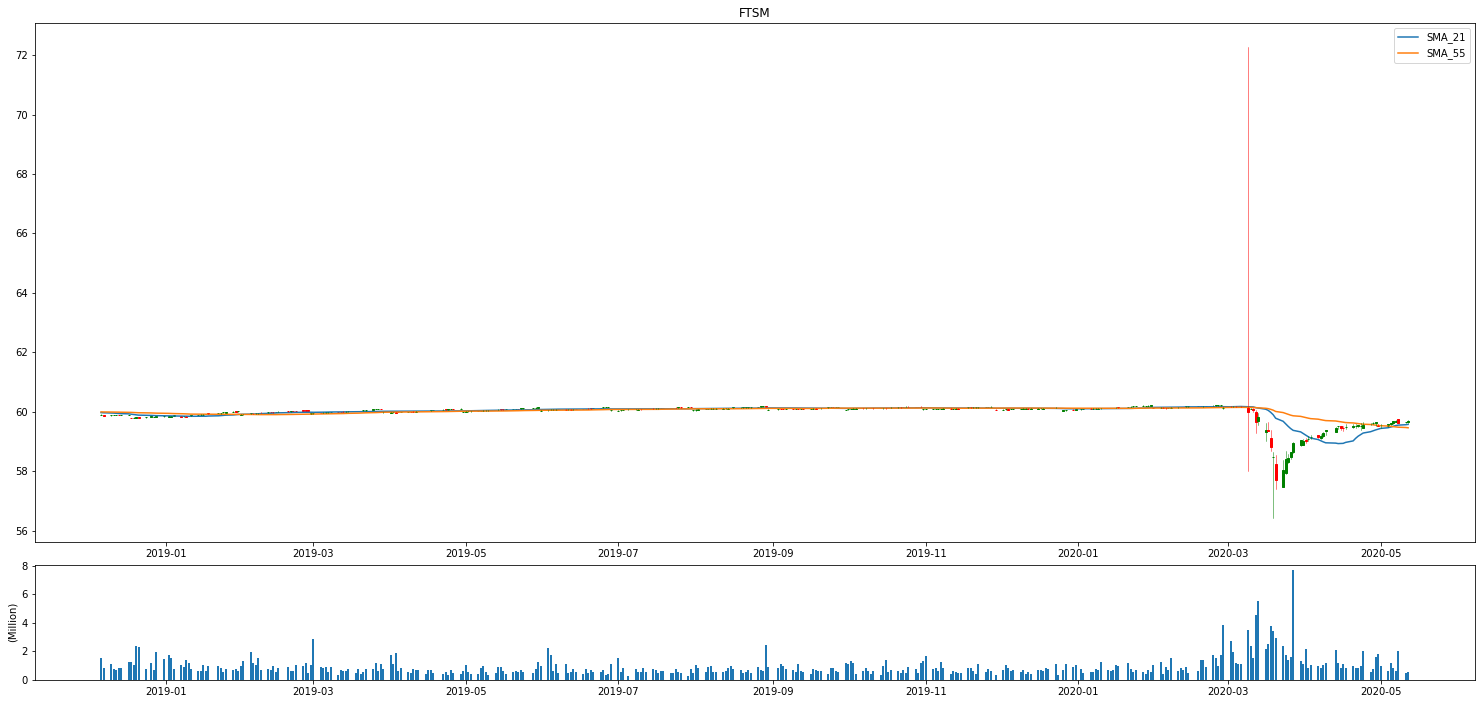

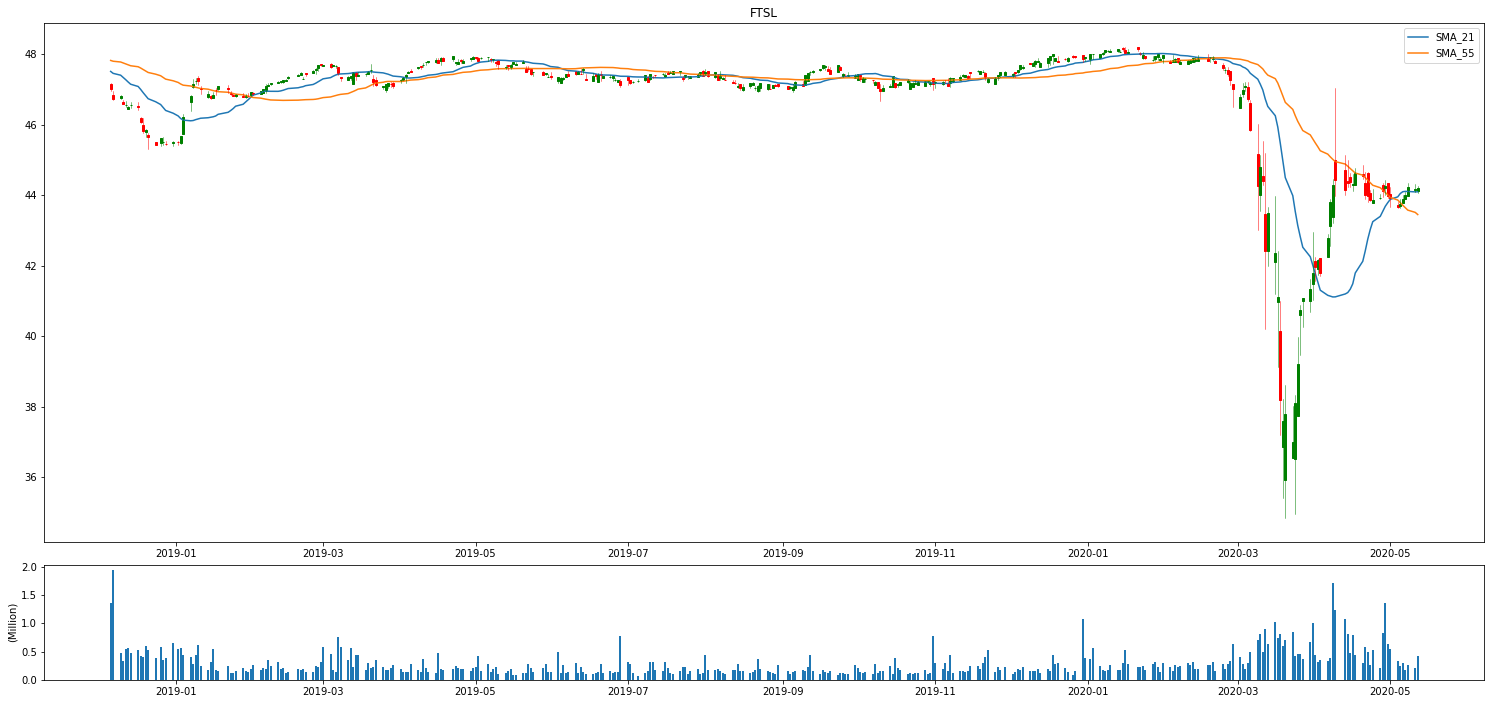

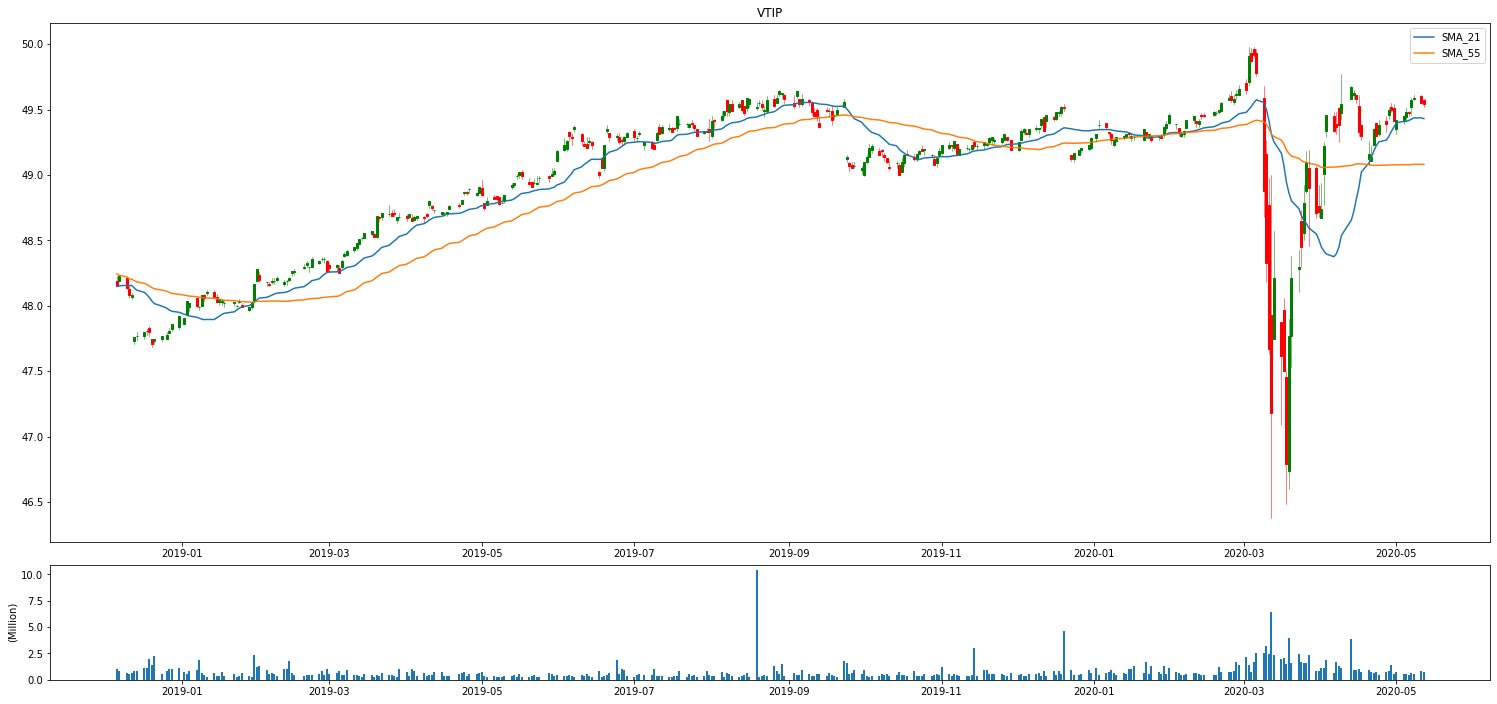

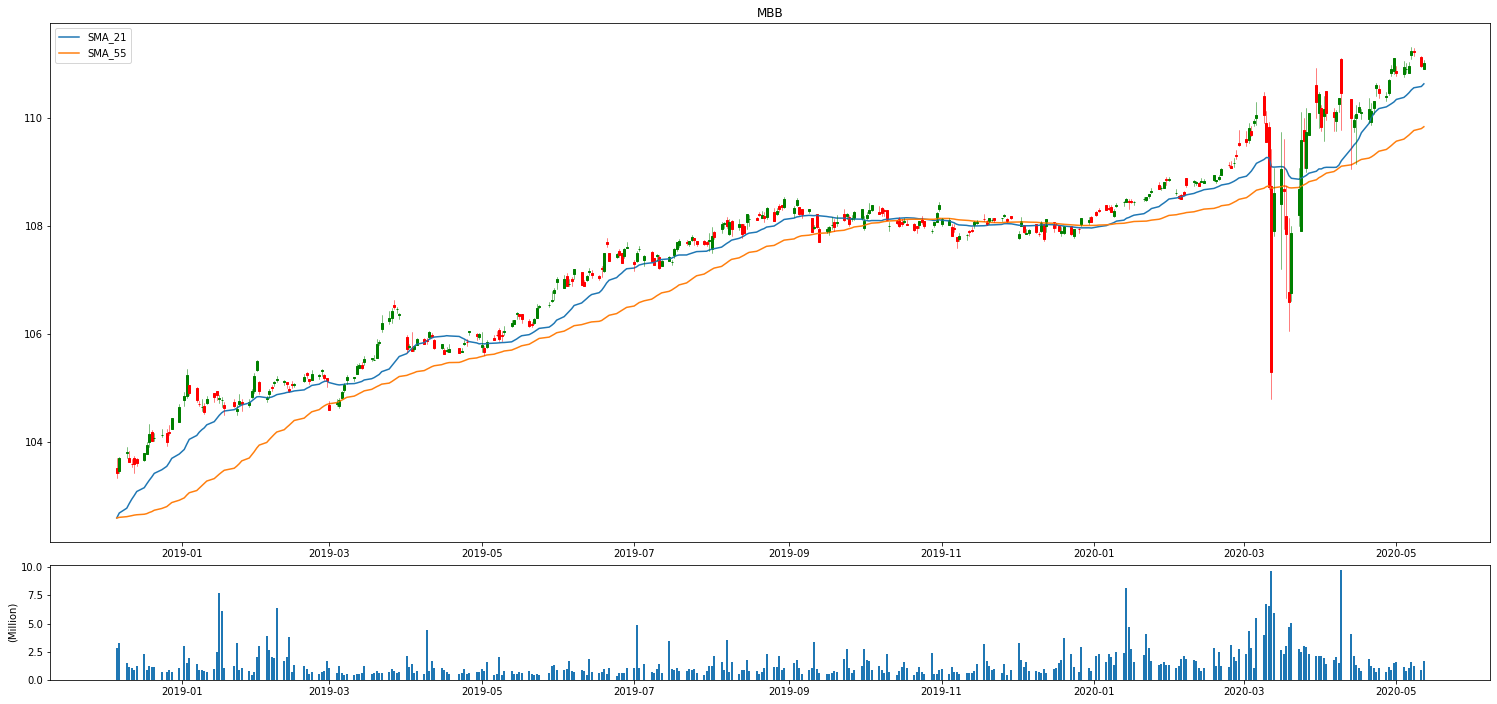

In [11]:
print(f"Found {len(stocks)} Matches")
for s, d in stocks.items():
    plot_chart(d, 360, s)